In [1]:
import pandas as pd
import numpy as np
import random as rnd
from termcolor import colored
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
%matplotlib inline

bold_start = '\033[1m'
underline_start = '\033[4m'
bu_end = '\033[0m'


In [2]:
train_df = pd.read_csv('death_prediction_synthetic.csv')

## Functions

In [3]:
def col_to_num(df):
    col_to_num= {}
    k = 0
    for col in df.columns:
        col_to_num[col] = k
        k += 1
    return col_to_num

In [4]:
def high_correlation_values(cor):
    sorted_cor = cor.unstack()
    sorted_cor = sorted_cor.sort_values()
    sorted_cor = sorted_cor.loc[((sorted_cor > 0.5) | (sorted_cor < -0.5)) & (sorted_cor != 1)]
    print(sorted_cor[::2])

In [5]:
def plot_correlation(df, method='pearson', cor_return = False):
    cor = df.corr(method=method)
    plt.figure(figsize=(28,28))
    plt.title("The method used: " + method[0].upper() + method[1:], fontsize=25)
    sns.heatmap(np.abs(round(cor, 3)), annot=True, cmap='Greys')
    plt.show() 
    if cor_return:
        return cor

In [6]:
def plot_null_features(df):
  d = df[['ACR','gravity_u','nitrites_u','leuko_u','proteinuria', 'albumin']]
  d.describe(include='all'), d.median()
  fig, axes = plt.subplots(nrows=6, ncols=2)
  fig.set_figheight(12)
  fig.set_figwidth(8)
  j = 0
  for col in d.columns:
    d.hist(column=col, bins=20, grid=False, ax=axes[j, 0])
    d[col].plot.kde(ax=axes[j, 1])
    title = col
    fontSize = 10
    colour = 'black'
    axes[j, 0].set_title(title, fontsize=fontSize, color=colour)
    axes[j, 1].set_title(title, fontsize=fontSize, color=colour)
    j+=1
  print("Uniuqe values:\n", pd.Series({col:d[col].unique() for col in d}))
  print(d.describe(include='all'))
  print("Median:\n", d.median())

## Globals

In [7]:
numberOfPeople = train_df.shape[0]
totalDeath = train_df["dead_5y"].sum()

### ___________________________________________________________________________________________________________________

Export data description

In [8]:
des_df = {  'attName':[],
            'count':[],
            'mean':[],
            'std':[], 
            'min':[], 
            '25%':[], 
            '50%':[], 
            '75%':[], 
            'max':[]
            }
for att in train_df.columns:
    description = train_df[att].describe(include='all')
    des_df['attName'].append(att)
    for key in list(des_df.keys())[1:]:
        try:
            des_df[key].append(description[key])
        except:
            des_df[key].append(np.NaN)
des_df = pd.DataFrame(data=des_df)
des_df.to_csv("description.csv")
des_df.head()

,attName,count,mean,std,min,25%,50%,75%,max
0,age,12438.0,43.501126,4.802035,30.0,41.0,45.0,48.0,49.0
1,sex,12438.0,1.468805,0.499046,1.0,1.0,1.0,2.0,2.0
2,marital_status,12438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ses,12438.0,1.677279,0.763641,1.0,1.0,1.0,2.0,3.0
4,residence_cd,12438.0,1.062631,0.242307,1.0,1.0,1.0,1.0,2.0


# Introduction and approch

The following will justify why we choose our approach. In summary, according to the Central Bureau of Statistics the data we are dealing with have a large rate of sick (causes of death) people. 

We decided to use unsupervised learning to classify the risk groups. Unsupervised learning allows us to automatically identify patterns in the data and classify them into risk groups. This is a more efficient way of dealing with data that has a large rate of sick people, as it requires less manual intervention and will provide more accurate results.

In [9]:
old_death_population = {
    2018: (1770, 2229702),
    2017: (1780, 2191646),
    2016: (1798, 2150096),
    2015: (1697, 2110721),
    2014: (1733, 2070562),
    2013: (1694, 2030785),
    2012: (1699, 1990188),
    2011: (1704, 1952624),
    }
print(f'{"Year":<8s} | {"Death":<10s} | {"Population":<10s} | {"DeathRate":<10s}')
for year in old_death_population.keys():
    death_rate_s = round((old_death_population[year][0]/old_death_population[year][1])*100, 4)
    print(f'{year:<8} | {old_death_population[year][0]:<10} | {old_death_population[year][1]:<10} | {death_rate_s:<10}%')

print(bold_start + underline_start+  f'{"Data":<8} | {totalDeath:<10} | {numberOfPeople:<10} | {str(round(totalDeath/numberOfPeople*100, 4)):<10}%' + bu_end)


Year     | Death      | Population | DeathRate 
2018     | 1770       | 2229702    | 0.0794    %
2017     | 1780       | 2191646    | 0.0812    %
2016     | 1798       | 2150096    | 0.0836    %
2015     | 1697       | 2110721    | 0.0804    %
2014     | 1733       | 2070562    | 0.0837    %
2013     | 1694       | 2030785    | 0.0834    %
2012     | 1699       | 1990188    | 0.0854    %
2011     | 1704       | 1952624    | 0.0873    %
Data     | 197        | 12438      | 1.5839    %


### Data preprocessing

The following section will be the data preparation, we'll preform data cleaning, transformation, selection etc. It's like putting together a puzzle; gathering the pieces, arranging them in the right order and ensuring no pieces are missing.

#### Null features

In [10]:
nullContainAtt = dict()
print(f'{"Feature":<14} {"Null Values":}  {"Null Rate":}')
for attName in train_df.columns:
    train_df[train_df == "NA"] = np.nan
    train_df[train_df == "NaN"] = np.nan
    numOfNulls = train_df[attName].isna().sum()
    if numOfNulls > 0:
        nullContainAtt[attName] = [numOfNulls, numOfNulls/numberOfPeople]
        print(f'{bold_start}{attName:<14} {numOfNulls:<10}{bu_end} {round(numOfNulls/numberOfPeople,2)*100:>10}%')
train_df[train_df == "NA"] = np.nan
train_df[train_df == "NaN"] = np.nan

Feature        Null Values  Null Rate
albumin        1463             12.0%
alb24h         8918             72.0%
ACR            1212             10.0%
gravity_u      2530             20.0%
nitrites_u     2520             20.0%
leuko_u        2507             20.0%
proteinuria    2506             20.0%


Uniuqe values:
 ACR            [6.0, 3.87, 6.35, 5.0, 0.48, 30.0, 4.16, 3.14,...
gravity_u      [1.025, 1.021, 1.03, 1.017, 1.028, 1.02, nan, ...
nitrites_u                                  [0.0, nan, 1.0, 2.0]
leuko_u        [0.0, 1.0, nan, 75.0, 100.0, 25.0, 250.0, 500....
proteinuria                                      [0.0, nan, 1.0]
albumin        [3.94, 4.5, nan, 4.6, 4.4, 4.8, 4.25, 4.3, 4.1...
dtype: object
                ACR    gravity_u   nitrites_u      leuko_u  proteinuria  \
count  11226.000000  9908.000000  9918.000000  9931.000000  9932.000000   
mean      38.829212     1.022250     0.037709    40.851576     0.050745   
std      117.962082     0.008226     0.202310   120.788718     0.219488   
min        0.000000     1.000000     0.000000     0.000000     0.000000   
25%        3.870000     1.016000     0.000000     0.000000     0.000000   
50%        7.000000     1.021000     0.000000     0.000000     0.000000   
75%       21.000000     1.028000     0.000000     0.000

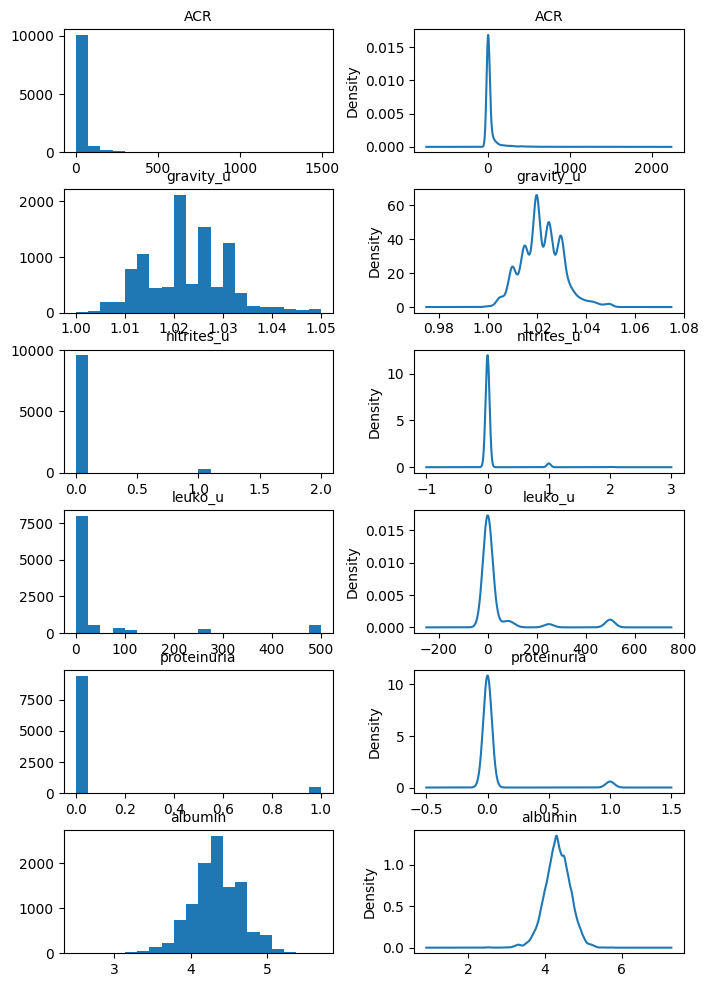

In [11]:
plot_null_features(train_df)

We'll first fix the **_ACR_** feature data by using the median and multiply it in normal distributed values

(<AxesSubplot: ylabel='Density'>,
 count    12438.000000
 mean        35.599379
 std        112.504784
 min          0.000000
 25%          3.510422
 50%          6.820000
 75%         18.000000
 max       1494.570000
 Name: ACR, dtype: float64)

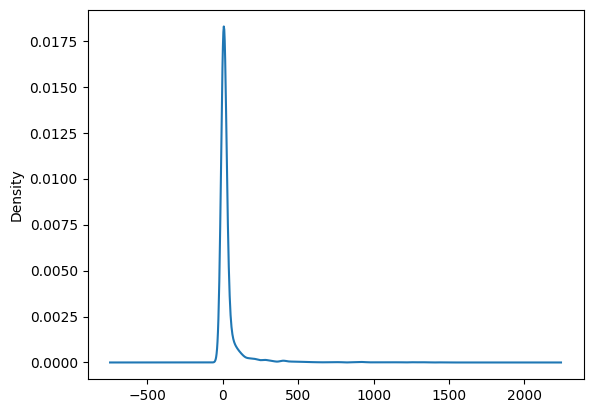

In [12]:
random_vals = pd.Series(np.abs(np.random.normal(size=1212)))
random_around_median = list(random_vals * train_df['ACR'].median())
acr_replacment = []
for i in train_df['ACR']:
    if math.isnan(i):
        acr_replacment.append(random_around_median.pop(0))
    else:
        acr_replacment.append(i)

train_df['ACR'] = pd.Series(acr_replacment)
train_df['ACR'].plot.kde(), train_df['ACR'].describe()

The **_gravity_u_** feature will be filled by previous row. The data distribution on albumin is more normal than gravity so well fill it with median whice is not sensetive to noise

In [13]:
# Categorize maybe?? "alb24h", "nitrites_u", "proteinuria", "leuko_u", 'gravity_u'
train_df['gravity_u'] = train_df['gravity_u'].fillna(method='ffill')
train_df['albumin'] = train_df['albumin'].fillna(train_df['albumin'].median()) 

The description file helps to understand that cancer have no effect so we'll remove this attribute
albumin have 70%+ missing values
nitrites and protein, leuko have 20% missing data and more than 50% of zeros

In [14]:
train_df = train_df.drop(["cancer", "alb24h", "nitrites_u", "proteinuria", "leuko_u"], axis=1)
train_df.head()

,age,sex,marital_status,ses,residence_cd,residence,weigh,heigh,BMI,bp_sys,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
0,49,2,U,1,1,urban,84.0,160.0,32.79,116,...,1,0.12908,1,0,0,1,1,1,0,0
1,46,2,M,1,1,urban,67.0,152.0,29.38,113,...,1,0.08500,1,0,0,0,1,1,0,0
2,46,2,U,1,1,urban,62.4,148.0,28.31,133,...,1,0.10715,1,0,0,1,1,1,0,0
3,45,1,U,2,1,urban,73.9,166.0,26.85,100,...,1,0.10110,1,0,0,0,0,1,0,0
4,49,2,U,1,1,urban,53.0,161.0,20.45,110,...,1,0.03950,1,0,0,0,0,1,0,0


In [15]:
# Transform the sex feature to binary - {1,2} --> {0,1}
train_df['sex'] = train_df['sex'] - 1
train_df['sex'].value_counts()

0    6607
1    5831
Name: sex, dtype: int64

#### Strings features

In [16]:
train_df.select_dtypes(exclude=['int64', 'float64'])

,marital_status,residence,bp_cat,smoking_status
0,U,urban,Normal,non_smoker
1,M,urban,Normal,non_smoker
2,U,urban,Pre-HTN,non_smoker
3,U,urban,Normal,current_smoker
4,U,urban,Normal,non_smoker
...,...,...,...,...
12433,U,urban,Pre-HTN,non_smoker
12434,M,urban,Normal,non_smoker
12435,U,urban,Normal,current_smoker
12436,M,urban,Normal,non_smoker


In [17]:
train_df['residence'].value_counts(), train_df['residence_cd'].value_counts()

(urban    11659
 rural      779
 Name: residence, dtype: int64,
 1    11659
 2      779
 Name: residence_cd, dtype: int64)

We can drop the string residence column since the residence and residence_cd columns both contain the same values. same for smoking

In [18]:
train_df = train_df.drop(["residence"], axis=1)

In [19]:
train_df['smoking_status'].value_counts(), train_df['smoking'].value_counts()

(non_smoker        7806
 current_smoker    3287
 past_smoker       1345
 Name: smoking_status, dtype: int64,
 1    7806
 3    3287
 2    1345
 Name: smoking, dtype: int64)

In [20]:
train_df = train_df.drop(columns='smoking_status', axis=1)

Married = 1, Unmarried = 0

In [21]:
train_df['marital_status'] = train_df['marital_status'].map({"U" : 0, "M": 1})


Converting string to integrs.

In [22]:
train_df['bp_cat'] = train_df['bp_cat'].map({"Normal": 0, "Pre-HTN": 1, "HTN-G1": 2, "HTN-G2": 3, "HTN-G3": 4}).astype(int)

In [23]:
train_df.loc[(train_df['bp_cat'] == 1)] # ????????????

,age,sex,marital_status,ses,residence_cd,weigh,heigh,BMI,bp_sys,bp_dias,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
2,46,1,0,1,1,62.40,148.0,28.31,133,87,...,1,0.10715,1,0,0,1,1,1,0,0
9,44,1,1,1,1,72.00,164.0,26.77,137,76,...,2,0.09586,1,0,0,0,0,0,0,0
10,33,0,1,1,1,112.00,185.0,32.72,130,80,...,1,0.03946,1,0,0,1,1,1,0,0
17,49,1,1,2,1,78.00,157.5,31.24,130,89,...,1,0.11276,1,0,0,1,1,1,1,0
19,45,0,0,2,1,83.00,169.0,29.06,117,86,...,1,0.08349,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12417,49,0,1,1,1,78.00,175.0,25.60,137,86,...,3,0.37036,1,0,0,1,1,1,1,0
12425,44,1,1,2,1,98.85,167.0,35.14,130,80,...,1,0.11030,1,0,0,0,0,1,0,0
12429,48,1,0,2,1,80.00,161.0,30.86,130,75,...,3,0.16726,1,0,0,0,0,1,1,0
12432,48,0,1,1,2,94.00,170.0,32.53,126,85,...,1,0.41173,1,0,0,1,1,1,0,0


In [24]:
max(train_df['bp_sys']), max(train_df['bp_dias']) #### ????

(200, 135)

We're done dealing with the features conatined nulls and strings.

#### Correlation - In the following part we'll deal with feature selection in order to avoid multicollinearity 

The first table shows the countnious features correlation, we'll deal the categorical features later.

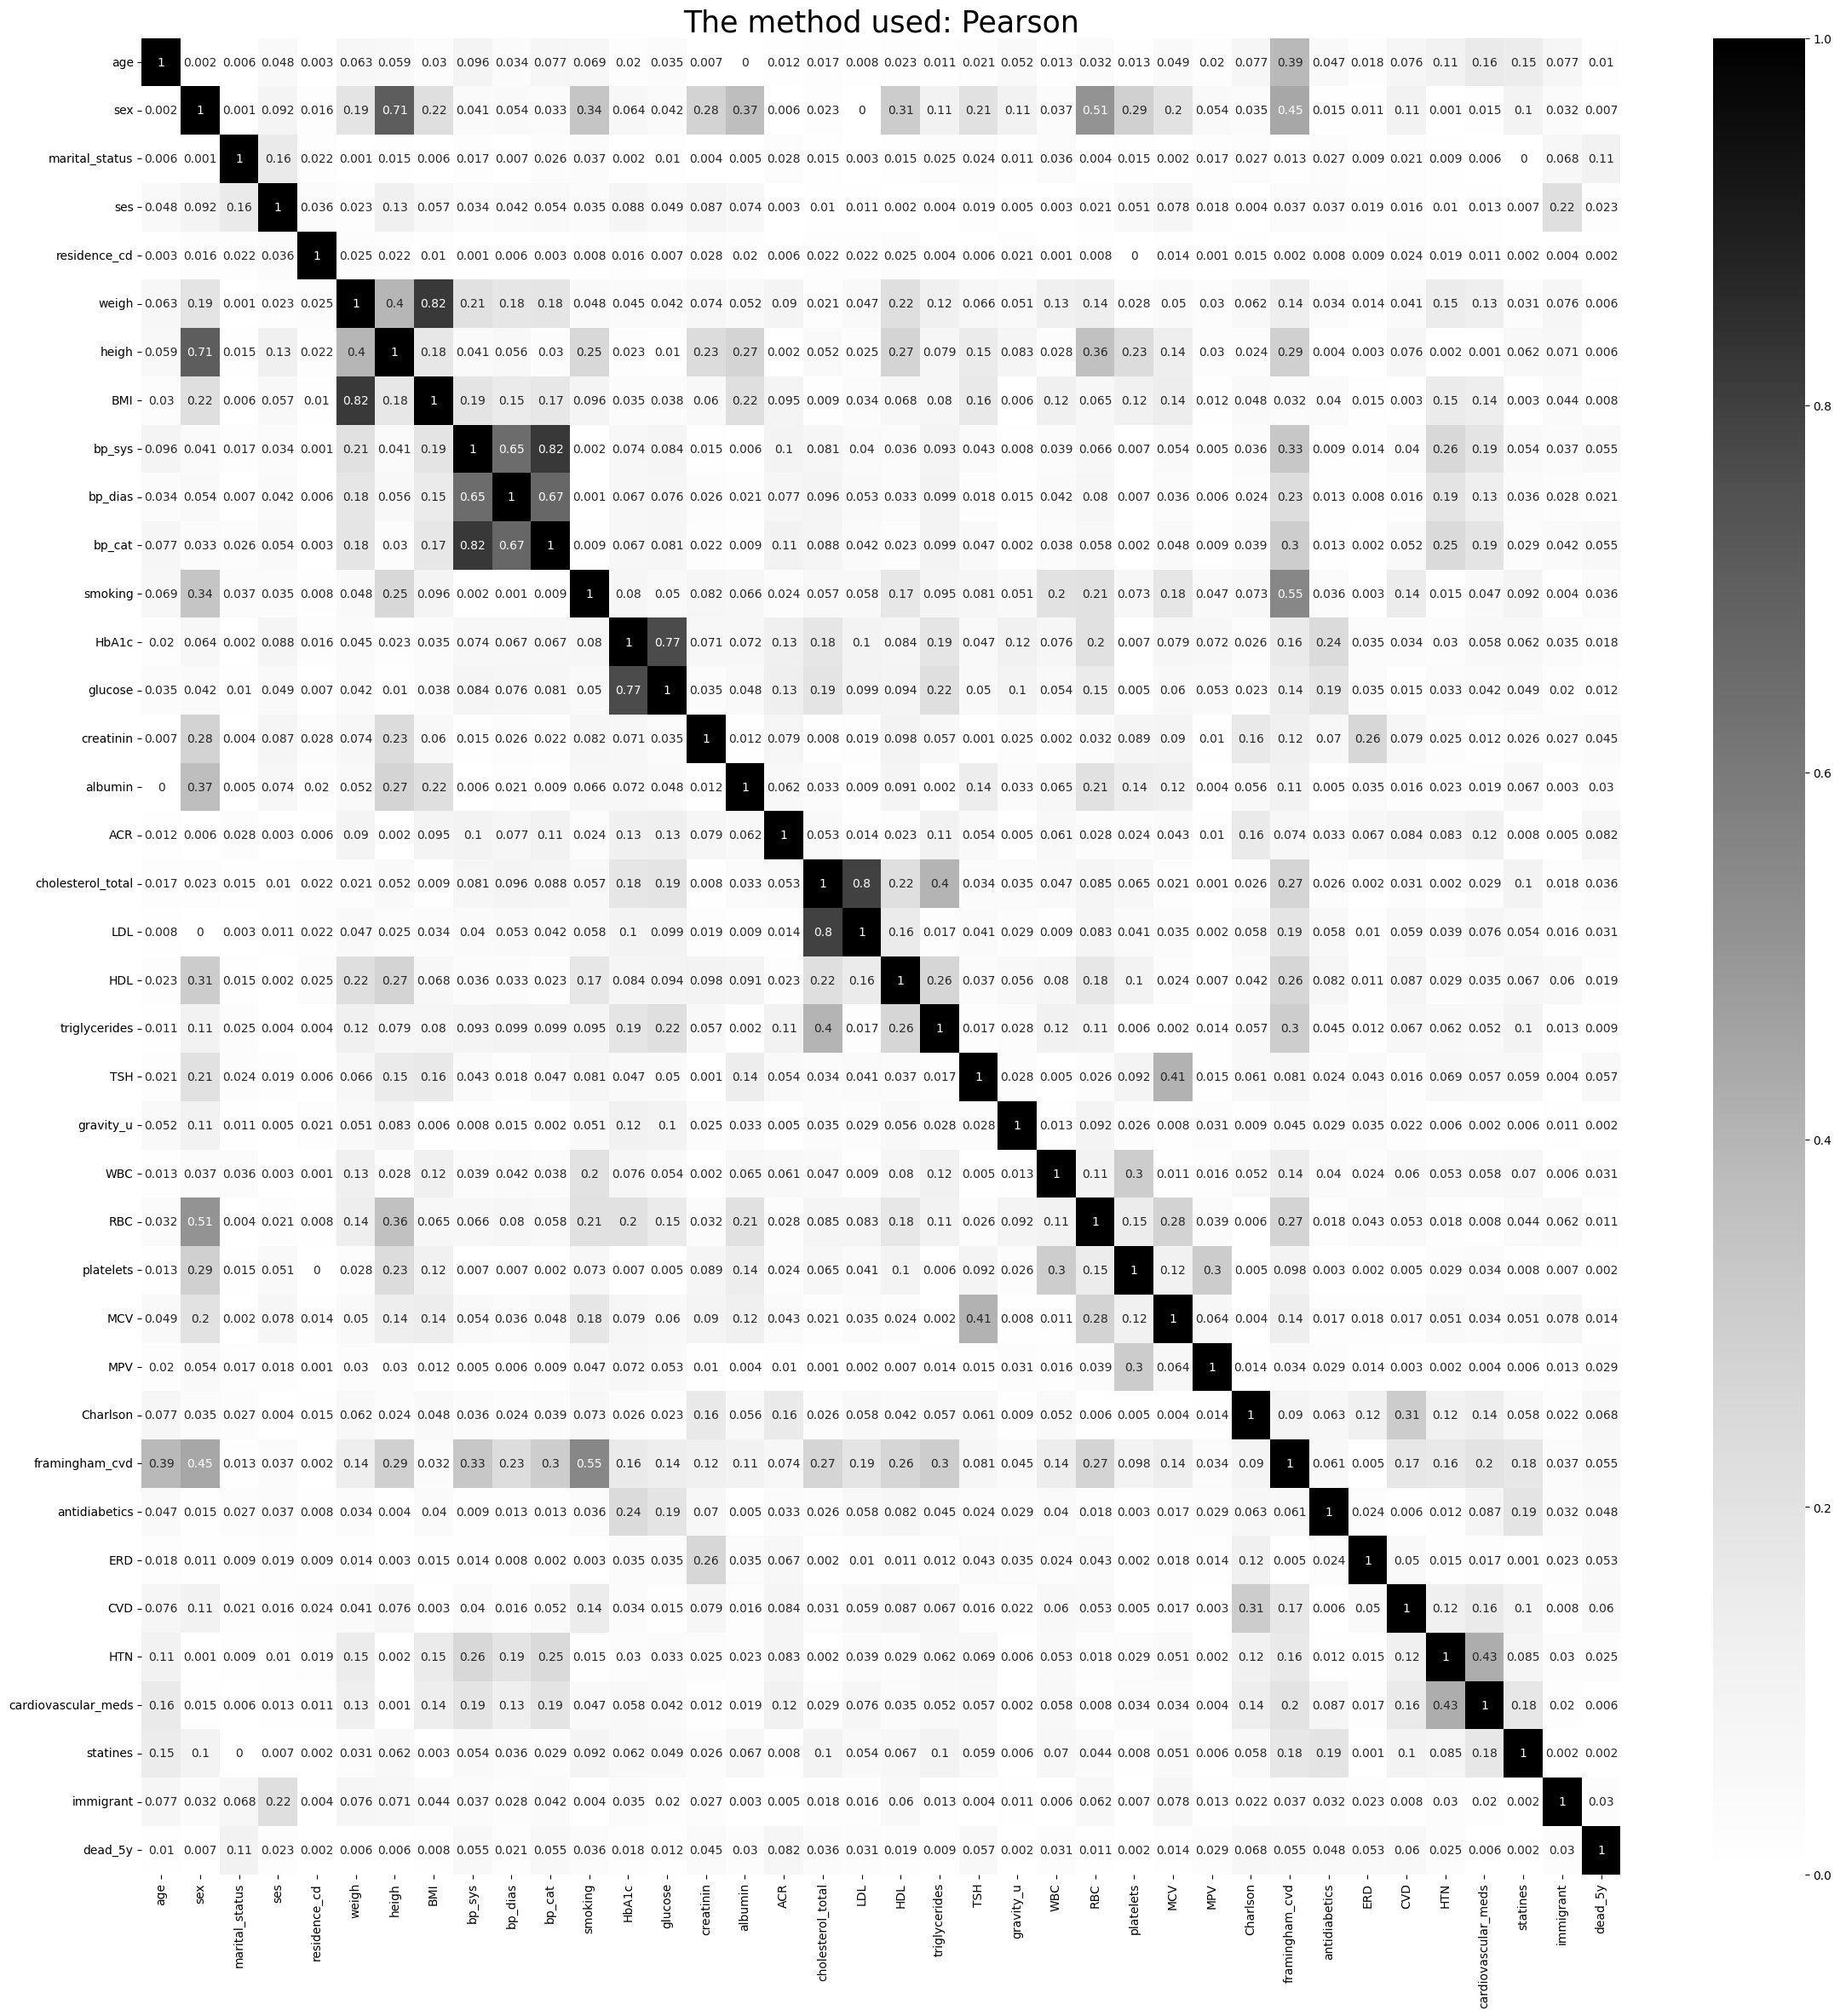

In [25]:
plot_correlation(train_df)

High correlation between bp_sys and bp_dias to bp cat so we use pca to reduce the dimensions and get two orthogonal vectors

In [26]:
# Save the data after transformation
train_df.to_csv('new_dataset.csv')

In [27]:
bp_pca = train_df[['bp_sys', 'bp_dias', 'bp_cat']]
pca = PCA(n_components=2)
pca.fit(bp_pca)
data_pca = pca.transform(bp_pca)
col_dict = col_to_num(train_df)
index = min(col_dict['bp_sys'],col_dict['bp_cat'], col_dict['bp_dias'])
train_df.insert(index, "new_bp_pca_1", 0)
train_df.insert(index+1, "new_bp_pca_2", 0)
train_df['new_bp_pca_1'] = data_pca[:, 0]
train_df['new_bp_pca_2'] = data_pca[:, 1]

לא סומכים על מדד הביאמי שניתן לנו, ניתן לראות שבחישוב מקומי הגדלנו את הקורלציות.

In [28]:
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')
train_df['BMI'] = train_df['weigh'] / (train_df['heigh'] ** 2)
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')

BMI <-> weigh 0.817, BMI <-> heigh -0.1784
BMI <-> weigh 0.8226, BMI <-> heigh -0.1803


In [29]:
train_df.to_csv('new_dataset.csv')

LDL and cholesterol total have high correlation, let's study it

(<AxesSubplot: xlabel='LDL', ylabel='Density'>,
 <AxesSubplot: xlabel='cholesterol_total', ylabel='Density'>)

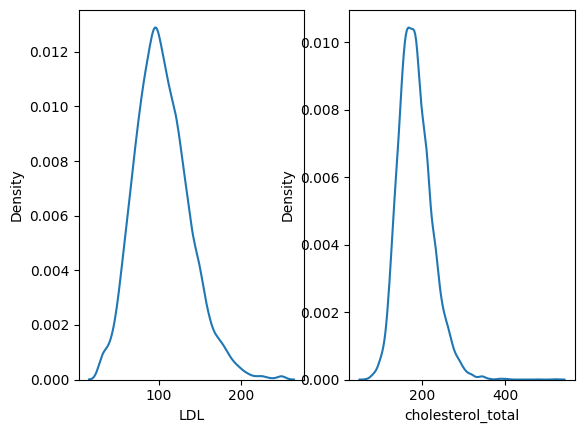

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
sns.kdeplot(train_df['LDL'], ax=ax), sns.kdeplot(train_df['cholesterol_total'], ax=ax1)

In [31]:
cor = train_df.corr()
cor['cholesterol_total'].loc[(np.abs(cor['cholesterol_total']) > 0.5) & (cor['cholesterol_total'] != 1)]

LDL    0.795632
Name: cholesterol_total, dtype: float64

We diceded to drop the cholesterol_total feature because it's high correlation and our understanding that LDL, triglycerides and HDL maps chorlesterol total and as we noticed on BMI feature we  can't trust this calculation


HbA1c and glucose are also in high correlation, multiplication helped to get high correlation from both features

In [32]:
print(train_df['HbA1c'].describe(), train_df['glucose'].describe())

count    12438.000000
mean         7.623666
std          1.867250
min          4.000000
25%          6.300000
50%          7.100000
75%          8.500000
max         16.800000
Name: HbA1c, dtype: float64 count    12438.000000
mean       153.757276
std         64.724782
min         40.000000
25%        110.000000
50%        134.000000
75%        177.000000
max        883.000000
Name: glucose, dtype: float64


In [33]:
train_df['mult_glu_HbA'] = train_df['HbA1c'] * train_df['glucose']

In [34]:
# So the multiplication of glucose and HbA1c works well, we can drop those features and stay with the new feature
# train_df = train_df.drop(["glucose", "HbA1c"], axis=1)

Let's take a look and spearman correlation matrix, more accurate for categorical features

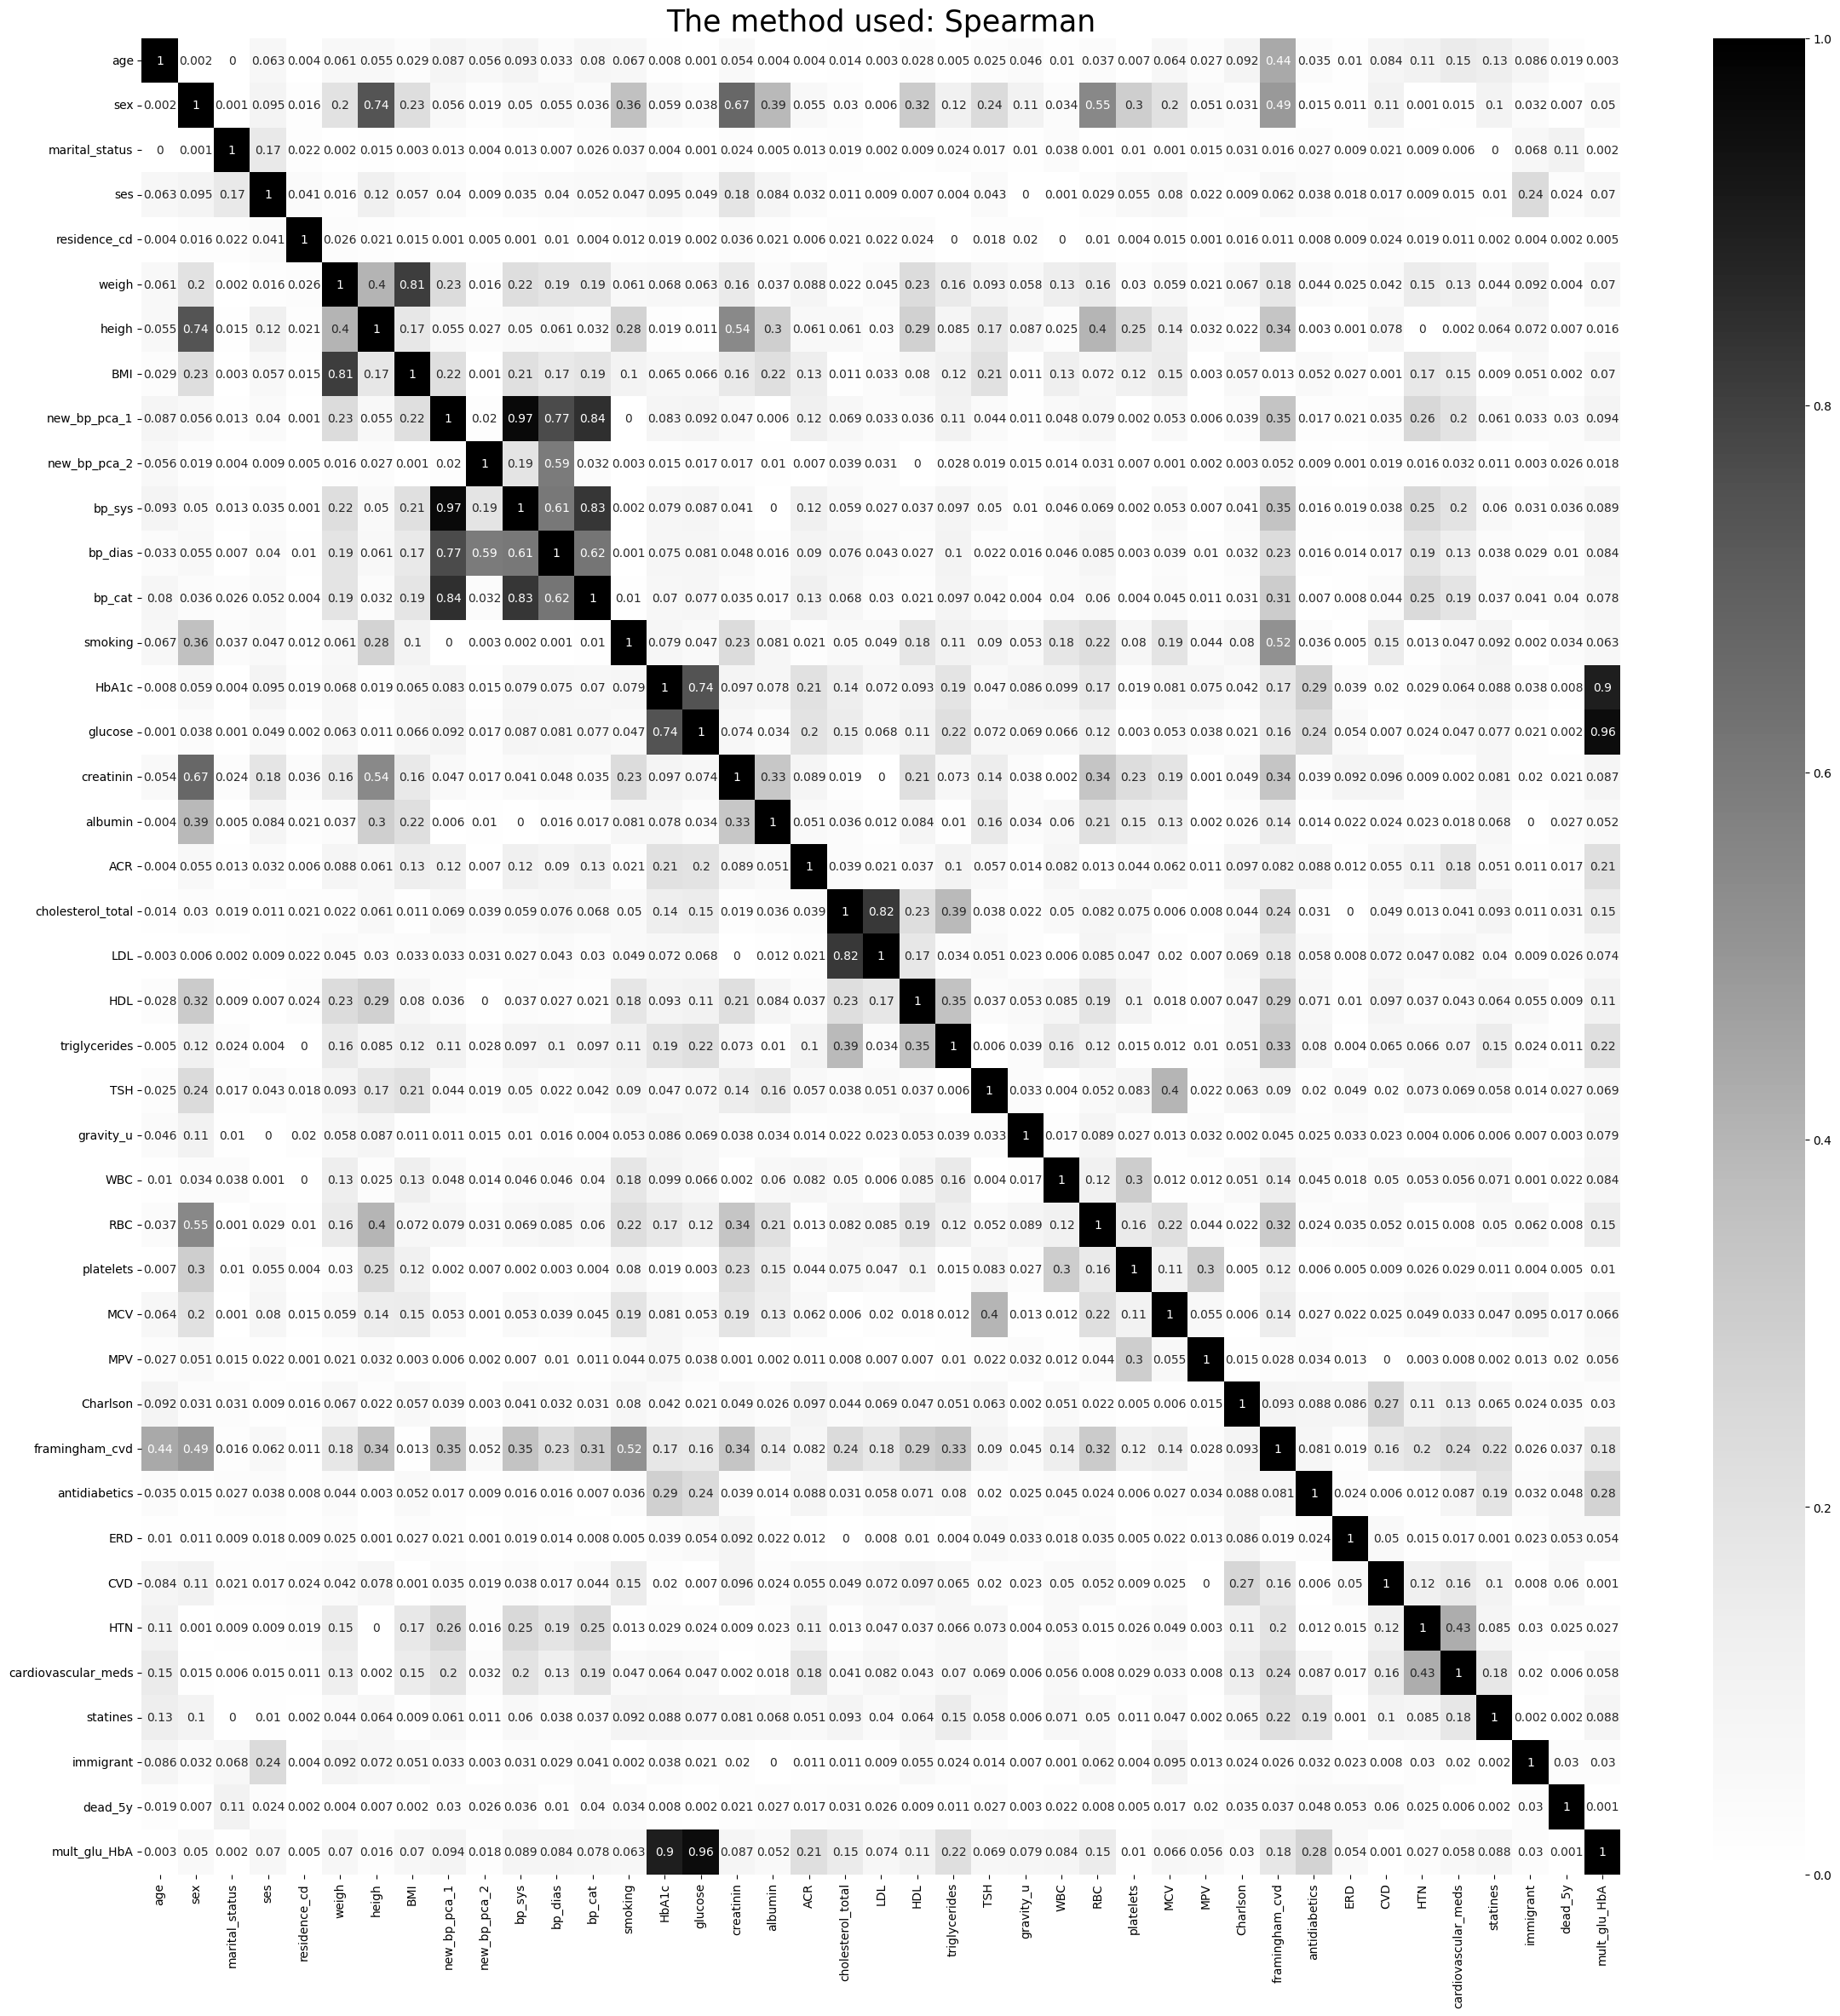

In [35]:
plot_correlation(train_df, 'spearman')

relations between sex and heigh make sense, we'll use TNSE for the dimension reduction because the data we want  to reduce is both binary and continous 

In [36]:
sex_pca = TSNE(2)
p =  sex_pca.fit_transform(train_df[['sex', 'RBC', 'creatinin']])
index = min(col_dict['RBC'], col_dict['creatinin'])
train_df.insert(index, 'new_tnse_1', 0)
train_df.insert(index+1, 'new_tnse_2', 0)
train_df['new_tnse_1'] = p[:, 0]
train_df['new_tnse_2'] = p[:, 1]

Visualizing new features mapping for their origins

In [ ]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

In [37]:
train_df = train_df.drop(['bp_sys', 'bp_dias', 'bp_cat', 'weigh', 'heigh',
'cholesterol_total', 'HbA1c', 'glucose', 'sex', 'RBC', 'creatinin'], axis=1)

Understaing the relations between farmingham rate and smoking

In [41]:
cvd_mean = train_df['framingham_cvd'].mean()

In [42]:
# Number of death people that are smoking and have high framingham rate
train_df['framingham_cvd'].loc[(train_df['framingham_cvd'] > cvd_mean) &(train_df['smoking'] > 1) & (train_df['dead_5y'] == 1)].count()

71

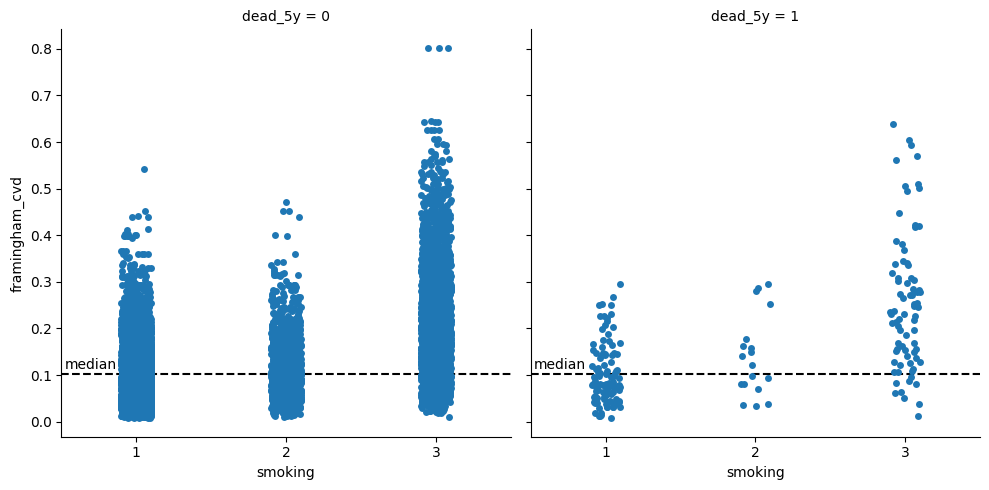

In [63]:
data = train_df[['framingham_cvd', 'smoking','dead_5y']]
f = sns.catplot(data=data, x='smoking', y='framingham_cvd', col='dead_5y')
f.axes[0][0].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')
f.axes[0][0].text(-0.48, y=train_df['framingham_cvd'].median()+0.01, s='median')
f.axes[0][1].text(-0.48, y=train_df['framingham_cvd'].median()+0.01, s='median')
f.axes[0][1].axhline(y=train_df['framingham_cvd'].median(), color='black', ls='--')

In [64]:
train_df = train_df.drop(['framingham_cvd'], axis=1)
train_df.shape

(12438, 31)

Now, correlations are removed

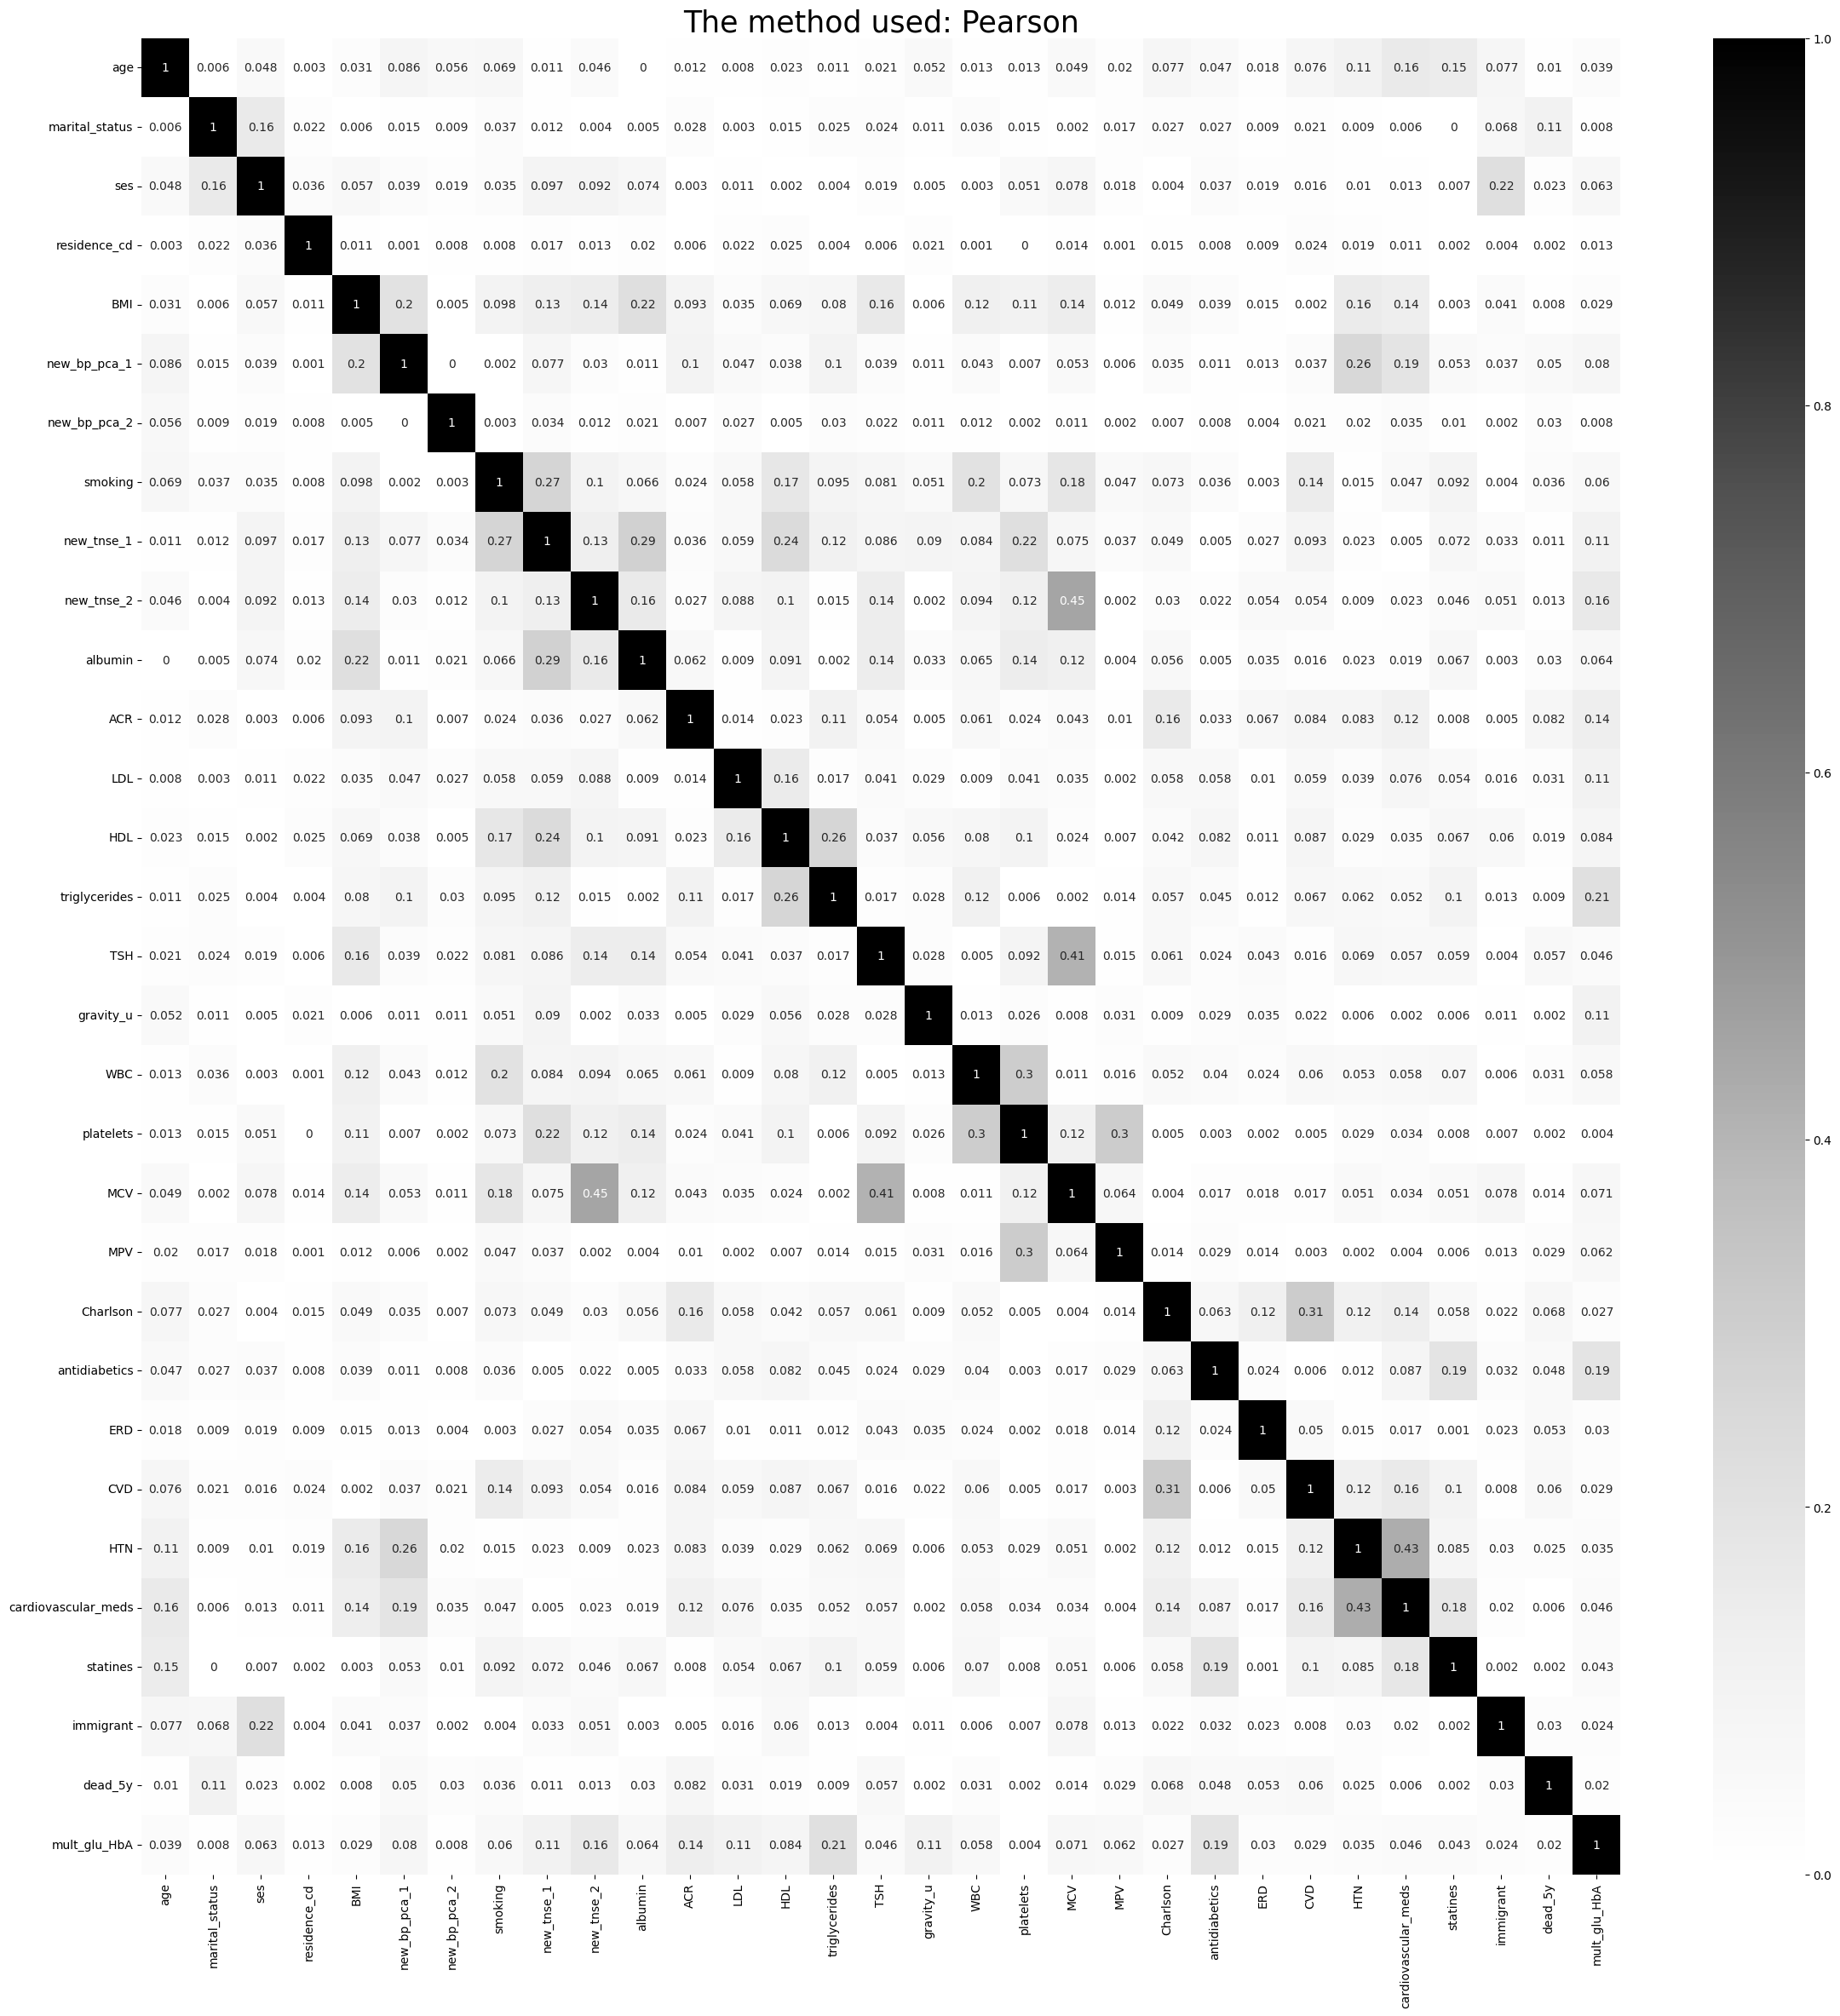

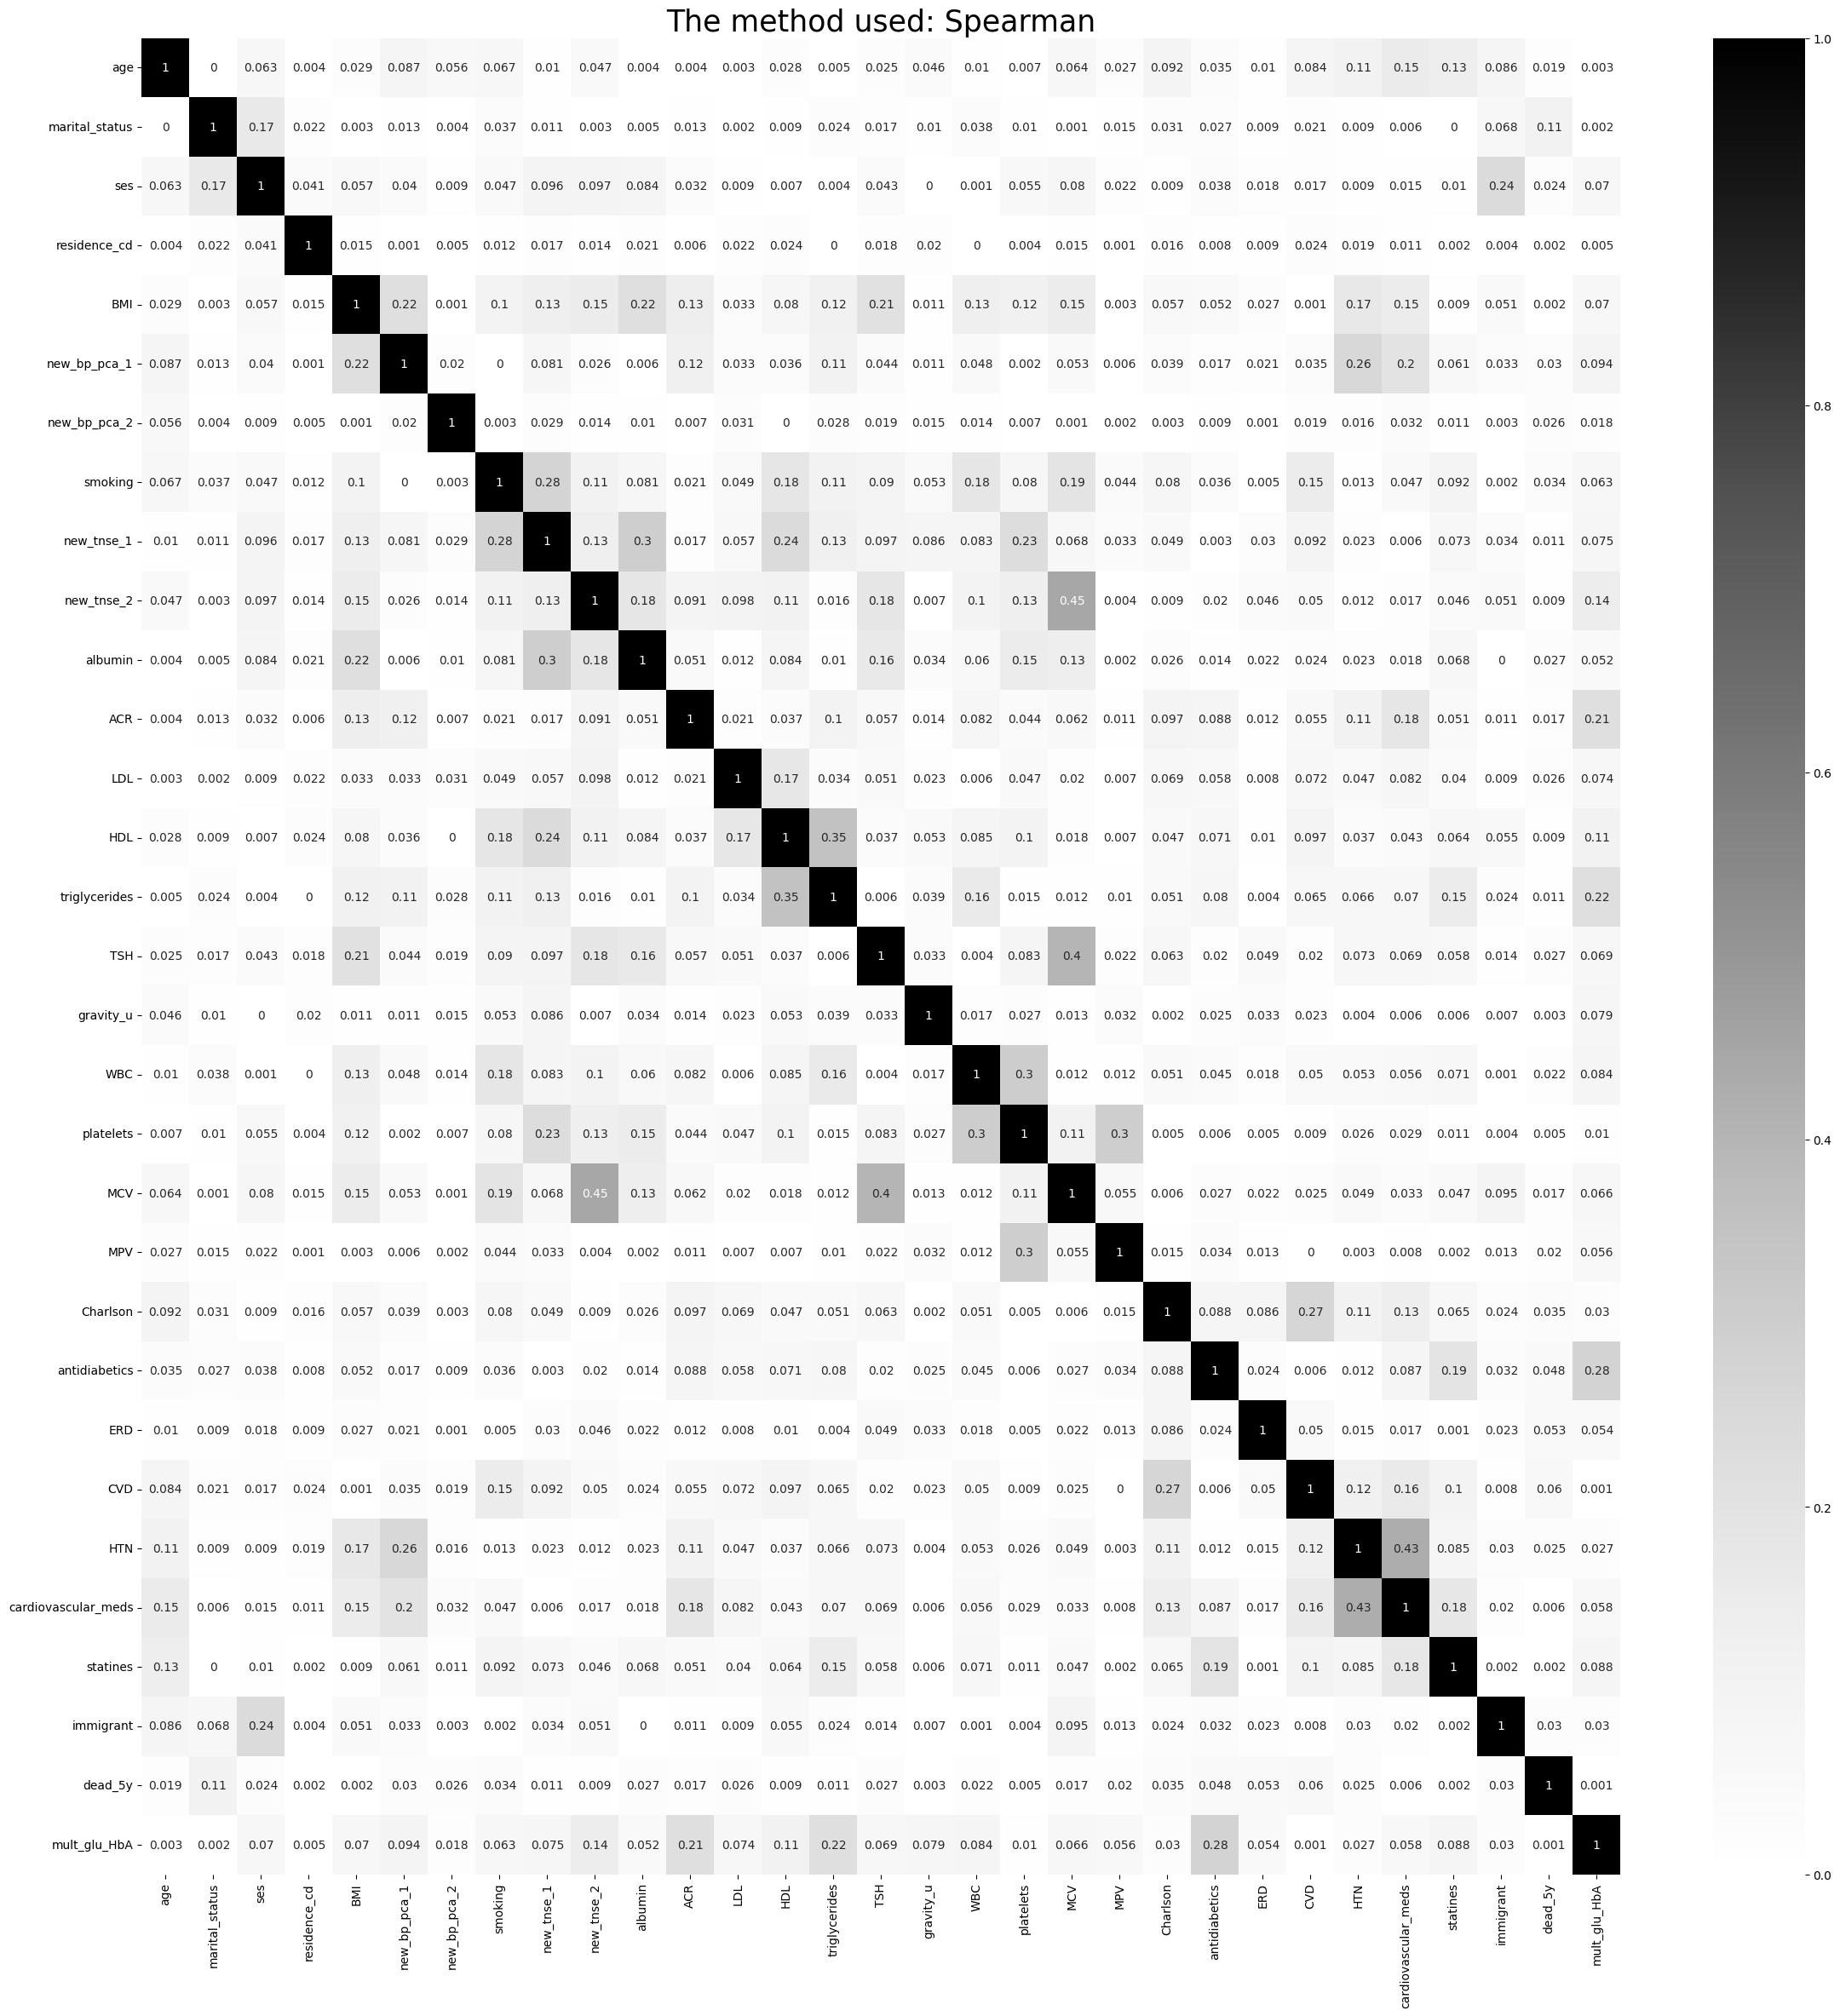

(None, None)

In [65]:
plot_correlation(train_df), plot_correlation(train_df, 'spearman')

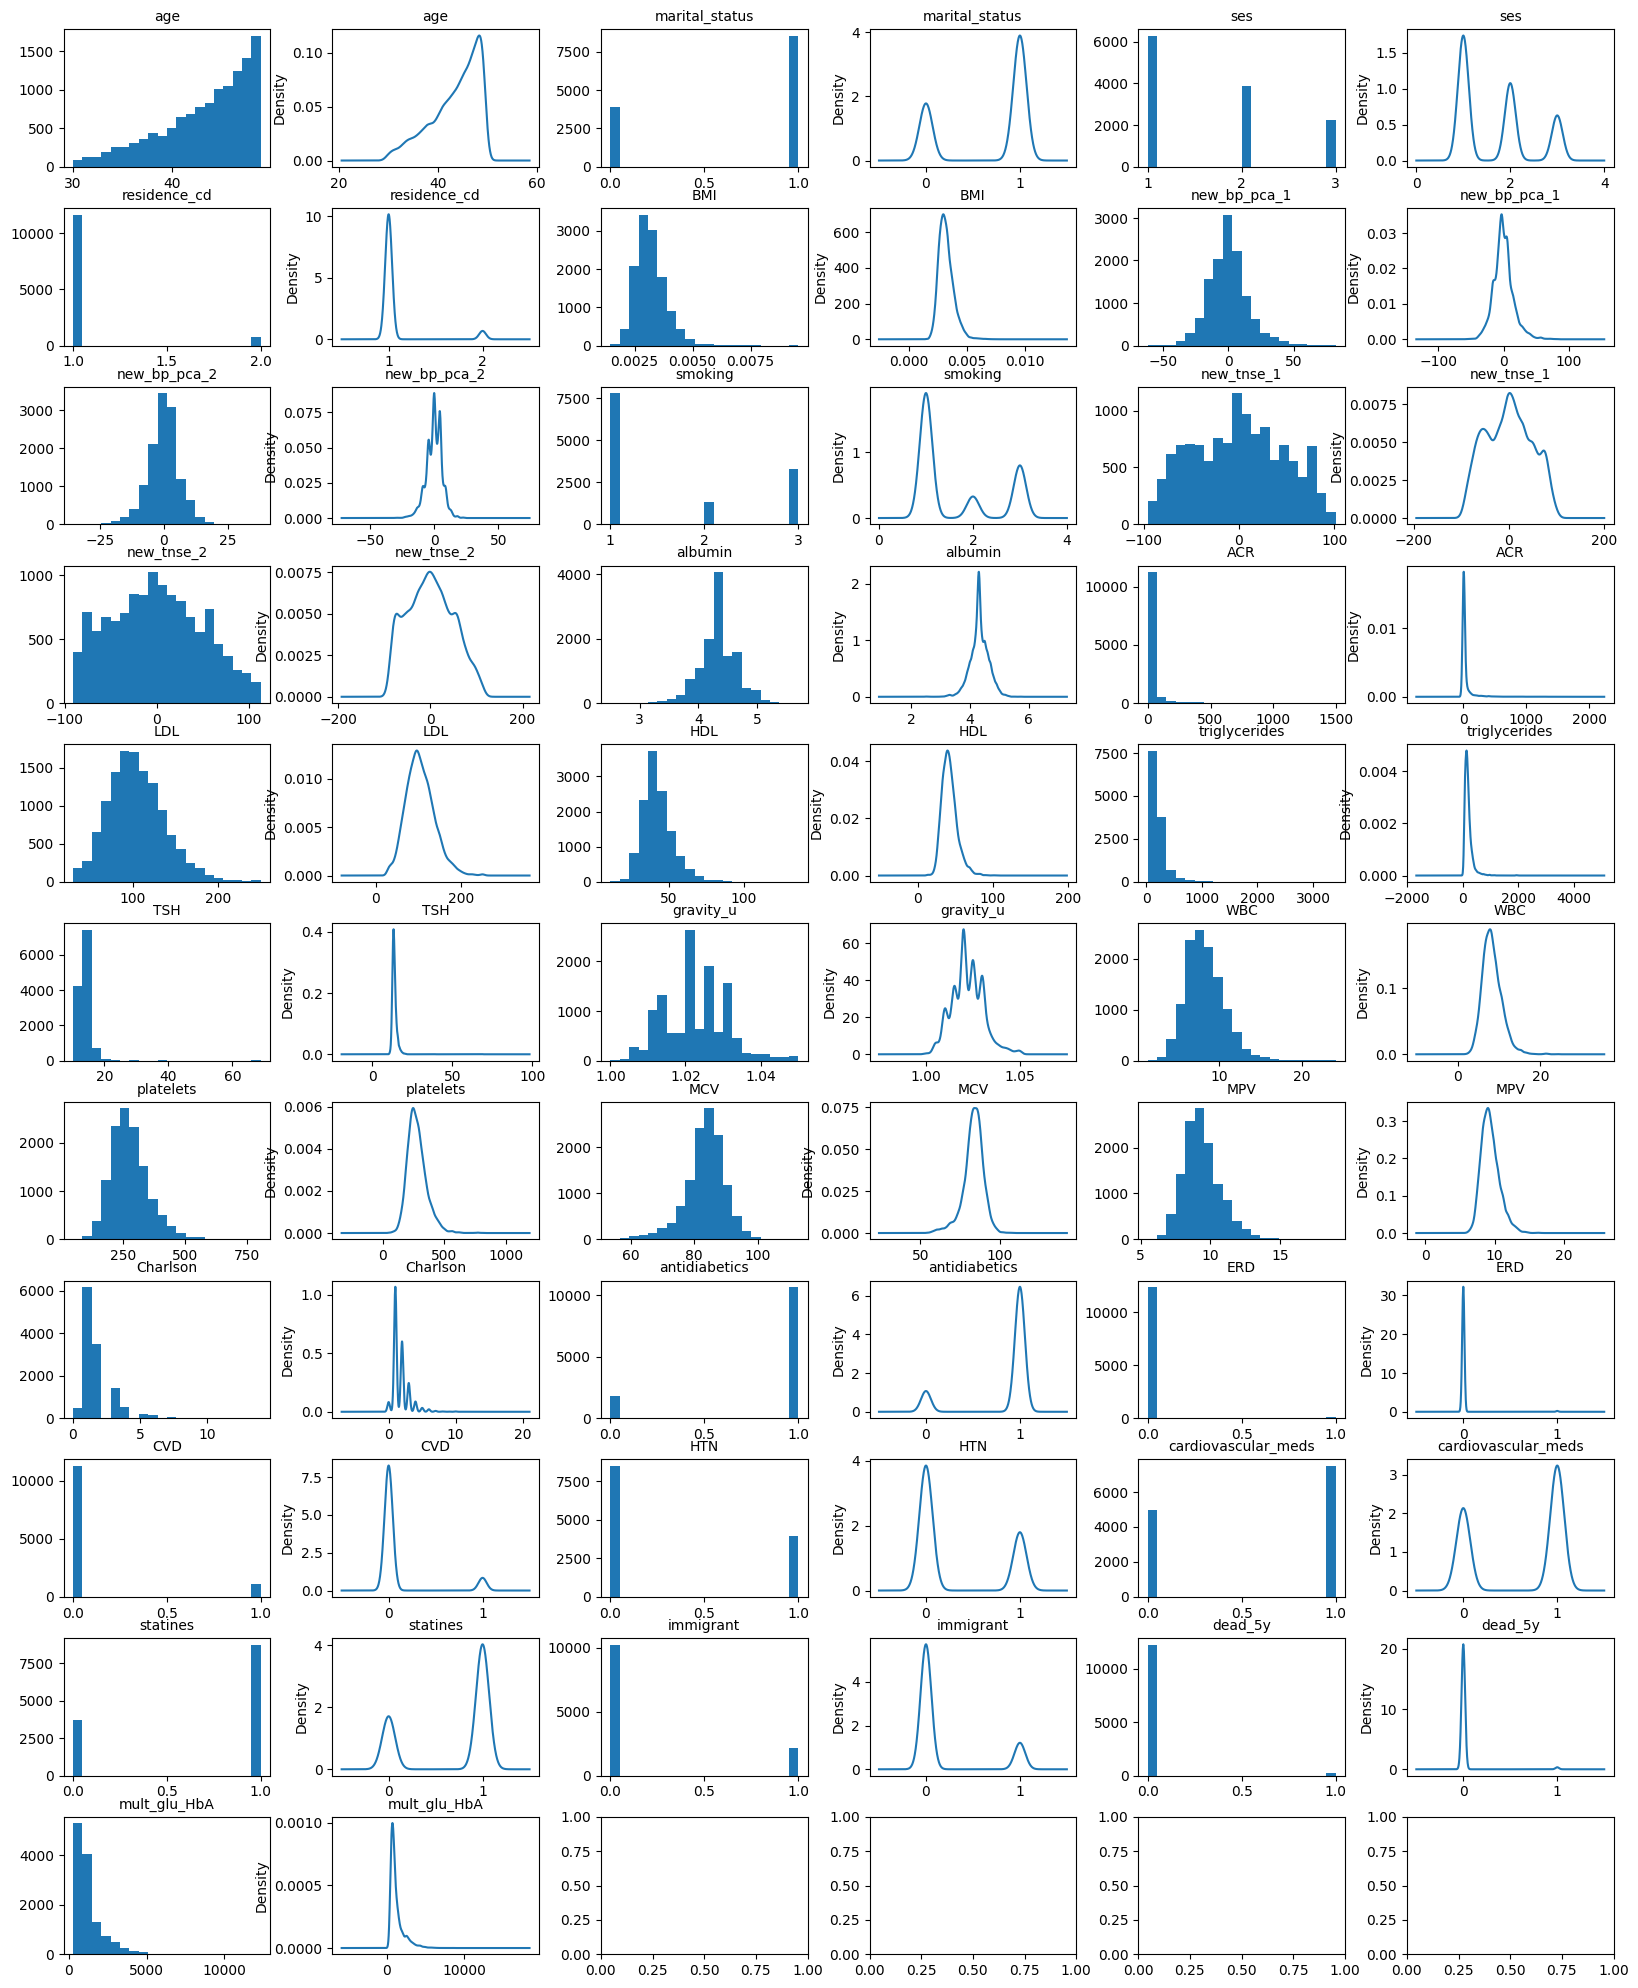

In [66]:
fig, axes = plt.subplots(nrows=11, ncols=6) 
fig.set_figheight(25)
fig.set_figwidth(20)
i = 0
j = 0
for col in train_df.columns:
  train_df.hist(column=col, bins=20, grid=False, ax=axes[i, j%3*2])
  train_df[col].plot.kde(ax=axes[i, j%3*2+1])
  title = col
  fontSize = 10
  colour = 'black'
  axes[i, j%3*2].set_title(title, fontsize=fontSize, color=colour)
  axes[i, j%3*2+1].set_title(title, fontsize=fontSize, color=colour)
  j += 1 
  if j % 3 == 0:
     i += 1

In [67]:
train_df.describe()

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,Charlson,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y,mult_glu_HbA
count,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,1.243800e+04,1.243800e+04,12438.000000,12438.000000,12438.000000,...,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000,12438.000000
mean,43.501126,0.686364,1.677279,1.062631,0.003187,4.451318e-15,8.180553e-16,1.636678,-0.311763,0.299436,...,1.755427,0.857694,0.006593,0.092057,0.318058,0.602669,0.702203,0.174867,0.015839,1265.016736
std,4.802035,0.463989,0.763641,0.242307,0.000649,1.509746e+01,6.121911e+00,0.871735,47.504292,49.172028,...,1.218773,0.349378,0.080931,0.289117,0.465741,0.489365,0.457308,0.379869,0.124856,891.027097
min,30.000000,0.000000,1.000000,1.000000,0.001453,-6.145859e+01,-3.537448e+01,1.000000,-95.726631,-90.907127,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,265.500000
25%,41.000000,0.000000,1.000000,1.000000,0.002738,-8.344269e+00,-4.196398e+00,1.000000,-39.934968,-38.293388,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,710.475000
50%,45.000000,1.000000,1.000000,1.000000,0.003101,-1.298131e+00,2.161271e-01,1.000000,-0.088472,-1.003490,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,950.400000
75%,48.000000,1.000000,2.000000,1.000000,0.003538,6.799706e+00,4.407531e+00,3.000000,35.050464,36.889856,...,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1464.000000
max,49.000000,1.000000,3.000000,2.000000,0.009555,8.209091e+01,3.769933e+01,3.000000,101.311104,113.139496,...,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12362.000000


NORMALIZE - (if it's distributaion looks like normal its in the normal list, otherwise in the mixed list)

In [68]:
normal_dist_lst = ['BMI', 'albumin', 'LDL', 'HDL', 'gravity_u', 'WBC', 'platelets', 'MCV', 'MPV', 'new_bp_pca_1', 'new_bp_pca_2', 'new_tnse_1', 'new_tnse_2']
mixed_dist_lst = ['age', 'ACR', 'TSH', 'Charlson', 'mult_glu_HbA']
min_max = pp.MinMaxScaler()
train_df[normal_dist_lst] = min_max.fit_transform(train_df[normal_dist_lst])
normalize = pp.Normalizer()
train_df[mixed_dist_lst] = normalize.fit_transform(train_df[mixed_dist_lst])

In [69]:
from imblearn.over_sampling import SMOTENC
from sklearn.cluster import MiniBatchKMeans

y = train_df['dead_5y']
x = train_df.copy()
x = x.drop('dead_5y', axis=1)
col_num_lst = col_to_num(x)
cat_list = list(train_df.columns)
for colname in train_df.columns:
    if colname in normal_dist_lst or colname in mixed_dist_lst or colname == 'dead_5y':
        cat_list.pop(cat_list.index(colname))
    else:
        cat_list[cat_list.index(colname)] = col_num_lst[colname]
cat_list

sm = SMOTENC(cat_list)
X_res, y_res = sm.fit_resample(x, y)
X_res.describe()

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,MPV,Charlson,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,mult_glu_HbA
count,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,...,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000,24482.000000
mean,0.046758,0.406299,1.718569,1.031819,0.216289,0.444589,0.475990,1.676824,0.494725,0.460034,...,0.296737,0.002089,0.879381,0.005882,0.085655,0.332162,0.644310,0.804428,0.126256,0.989649
std,0.021681,0.491152,0.785758,0.175522,0.083632,0.113456,0.082455,0.914842,0.220889,0.253264,...,0.097555,0.002105,0.325691,0.076469,0.279859,0.470999,0.478732,0.396649,0.332144,0.045096
min,0.003695,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348687
25%,0.030007,0.000000,1.000000,1.000000,0.156078,0.374492,0.426666,1.000000,0.324964,0.258775,...,0.225780,0.000861,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.996796
50%,0.045335,0.000000,2.000000,1.000000,0.206038,0.430160,0.483076,1.000000,0.494558,0.442613,...,0.281481,0.001440,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.998325
75%,0.061423,1.000000,2.000000,1.000000,0.263049,0.498947,0.535283,3.000000,0.640842,0.644350,...,0.355556,0.002598,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.999192
max,0.177681,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,0.028612,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999991


In [70]:
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, train_size=0.8)


In [71]:
from sklearn.cluster import KMeans, BisectingKMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

kmeans = MiniBatchKMeans(n_clusters=3, verbose=0)
clusters = kmeans.fit_predict(x_train, y_train)
test_clusterd = kmeans.predict(x_test)


C:\Users\talro\machineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
test_clusterd_df = x_test
test_clusterd_df['class'] = test_clusterd
test_clusterd_df['dead_5y'] = y_test
clusterd_df = x_train
clusterd_df['class'] = clusters
clusterd_df['dead_5y'] = y_train
clusterd_df

,age,marital_status,ses,residence_cd,BMI,new_bp_pca_1,new_bp_pca_2,smoking,new_tnse_1,new_tnse_2,...,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,mult_glu_HbA,class,dead_5y
17382,0.076991,0,2,1,0.137658,0.365470,0.431096,1,0.373255,0.879920,...,1,0,0,0,0,1,1,0.996786,0,1
19189,0.065667,0,1,1,0.104651,0.601407,0.451604,1,0.601253,0.115170,...,1,0,0,1,1,1,0,0.997391,1,1
20235,0.065629,0,2,1,0.148072,0.398539,0.460253,1,0.383759,0.817202,...,1,0,0,0,1,1,0,0.997527,1,1
9858,0.030688,1,1,1,0.182972,0.365887,0.482204,1,0.619410,0.787395,...,1,0,0,0,0,0,0,0.999460,1,0
15548,0.047055,0,2,1,0.260744,0.325911,0.432503,1,0.156500,0.591127,...,1,0,0,0,0,1,0,0.998631,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7970,0.039905,0,1,1,0.223708,0.592107,0.354357,2,0.764868,0.312386,...,1,0,0,0,1,1,0,0.999099,0,0
18152,0.045007,0,1,1,0.216220,0.482052,0.469428,3,0.492813,0.740552,...,1,0,0,0,0,1,0,0.998831,0,1
8876,0.072210,1,1,1,0.232564,0.345810,0.611795,1,0.846323,0.151100,...,1,0,0,0,0,1,0,0.997118,1,0
7780,0.018492,1,2,1,0.258767,0.367947,0.402512,3,0.872572,0.159128,...,1,0,0,0,0,1,0,0.996763,2,0


In [73]:
def print_death_rate(df, class_num):
    class_num = class_num
    class_2_death = df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 1)].count()
    class_2_live = df['age'].loc[(df['class'] == class_num) & (df['dead_5y'] == 0)].count()
    class_2_total = df['age'].loc[(df['class'] == class_num)].count()
    print("Class:", class_num)
    print(f"Dath rate: {np.round(class_2_death/class_2_total,4)}, Total: {class_2_total}, Alive: {class_2_live}, Dead: {class_2_death}")

In [74]:
print_death_rate(clusterd_df, 0)
print_death_rate(clusterd_df, 1)
print_death_rate(clusterd_df, 2)

Class: 0
Dath rate: 0.4813, Total: 10998, Alive: 5705, Dead: 5293
Class: 1
Dath rate: 0.5148, Total: 7661, Alive: 3717, Dead: 3944
Class: 2
Dath rate: 0.5648, Total: 926, Alive: 403, Dead: 523


In [75]:
print_death_rate(test_clusterd_df, 0)
print_death_rate(test_clusterd_df, 1)
print_death_rate(test_clusterd_df, 2)

Class: 0
Dath rate: 0.4871, Total: 2792, Alive: 1432, Dead: 1360
Class: 1
Dath rate: 0.5281, Total: 1848, Alive: 872, Dead: 976
Class: 2
Dath rate: 0.5642, Total: 257, Alive: 112, Dead: 145


In [83]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

In [84]:
def model_accuracy(model, X_train, Y_train, X_test, Y_test):
    kfold = KFold(n_splits=10)
    model.fit(X_train, Y_train)
    acc_model_test = round(model.score(X_test, Y_test) * 100, 2)
    res_kfold = np.round(cross_val_score(model, X_test, Y_test, cv=kfold).mean()*100 ,2)
    print("Holdout Validation:",acc_model_test)
    print("K cross validation: ",res_kfold)


In [85]:
log_reg = LogisticRegression()
model_accuracy(log_reg, x_train, y_train, x_test, y_test)

Holdout Validation: 80.0
K cross validation:  79.69


In [86]:
svc = SVC()
model_accuracy(svc, x_train, y_train, x_test, y_test)

Holdout Validation: 54.8
K cross validation:  52.86


In [87]:
l_svc= LinearSVC()
model_accuracy(l_svc, x_train, y_train, x_test, y_test)

Holdout Validation: 70.82
K cross validation:  71.12


In [88]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=50)
model_accuracy(rfc, x_train, y_train, x_test, y_test)

Holdout Validation: 94.08
K cross validation:  85.71


In [89]:
knc = KNeighborsClassifier()
model_accuracy(knc, x_train, y_train, x_test, y_test)

Holdout Validation: 82.35
K cross validation:  73.67


In [90]:
gnb= GaussianNB()
model_accuracy(gnb, x_train, y_train, x_test, y_test)

Holdout Validation: 74.59
K cross validation:  74.39


In [91]:
percep = Perceptron()
model_accuracy(percep, x_train, y_train, x_test, y_test)

Holdout Validation: 57.86
K cross validation:  57.45


In [92]:
sdgc = SGDClassifier()
model_accuracy(sdgc, x_train, y_train, x_test, y_test)

Holdout Validation: 56.43
K cross validation:  55.2


In [93]:
dtc = DecisionTreeClassifier()
model_accuracy(dtc, x_train, y_train, x_test, y_test)

Holdout Validation: 85.71
K cross validation:  77.65
